In [1]:
"""
Appendix Figures (A1–A3)

This notebook generates supplementary figures for the project appendix.
It relies exclusively on the final processed panel and does not modify data.
"""

'\nAppendix Figures (A1–A3)\n\nThis notebook generates supplementary figures for the project appendix.\nIt relies exclusively on the final processed panel and does not modify data.\n'

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

p = Path.cwd().resolve()
while not (p / "src").exists() and p != p.parent:
    p = p.parent

if not (p / "src").exists():
    raise RuntimeError("Could not find project root containing 'src' folder")

sys.path.insert(0, str(p))
print("Project root:", p)

from src.evaluation import find_best_threshold

DATA_PATH = p / "data" / "processed" / "oecd_panel_2010_2023.csv"
FIG_PATH  = p / "results" / "appendix"
FIG_PATH.mkdir(parents=True, exist_ok=True)

plt.style.use("default")
from src.data_loader import load_panel, chronological_split, FEATURE_COLS

Project root: /Users/martinsinishta/Desktop/oecd-decoupling-classifier


In [16]:
df = pd.read_csv(DATA_PATH)

assert {"gdp_growth", "delta_co2", "decoupled", "year"}.issubset(df.columns)
df.head()


,country,iso3,year,co2,co2_per_capita,delta_co2,gdp_growth,decoupled
0,Australia,AUS,2010,405.026,18.293,-1.951,2.219980,1.0
1,Australia,AUS,2011,403.874,17.966,-1.152,2.407080,1.0
2,Australia,AUS,2012,405.005,17.722,1.131,3.916709,0.0
3,Australia,AUS,2013,397.850,17.122,-7.155,2.602193,1.0
4,Australia,AUS,2014,392.610,16.639,-5.240,2.595284,1.0


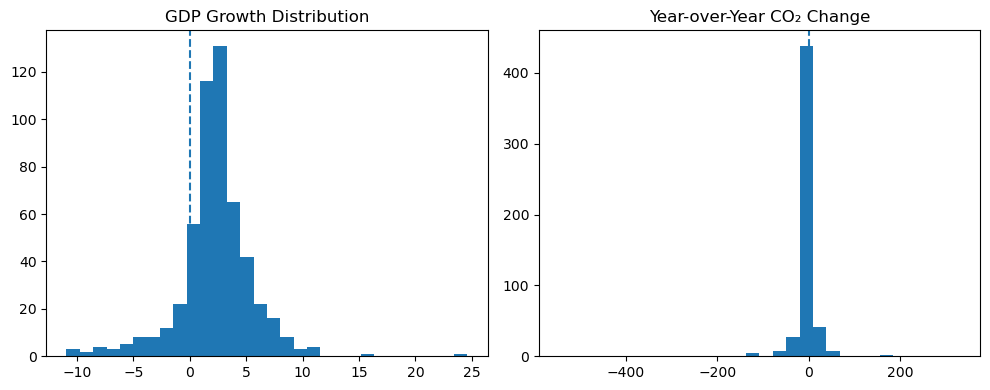

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df["gdp_growth"], bins=30)
axes[0].axvline(0, linestyle="--")
axes[0].set_title("GDP Growth Distribution")

axes[1].hist(df["delta_co2"], bins=30)
axes[1].axvline(0, linestyle="--")
axes[1].set_title("Year-over-Year CO₂ Change")

plt.tight_layout()
plt.savefig(FIG_PATH / "figure_A1_distributions.png", dpi=300)
plt.show()


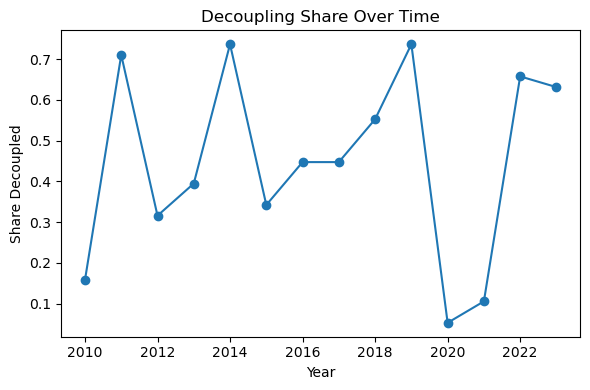

In [18]:
share_by_year = (
    df.groupby("year")["decoupled"]
      .mean()
)

plt.figure(figsize=(6,4))
plt.plot(share_by_year.index, share_by_year.values, marker="o")
plt.ylabel("Share Decoupled")
plt.xlabel("Year")
plt.title("Decoupling Share Over Time")

plt.tight_layout()
plt.savefig(FIG_PATH / "figure_A2_decoupling_share.png", dpi=300)
plt.show()

In [19]:
out = chronological_split(df)
print("len(out):", len(out))

for i, obj in enumerate(out):
    print(f"\n--- out[{i}] ---")
    print("type:", type(obj))
    if hasattr(obj, "shape"):
        print("shape:", obj.shape)
    if hasattr(obj, "columns"):
        print("first columns:", list(obj.columns)[:15])


len(out): 9

--- out[0] ---
type: <class 'pandas.core.frame.DataFrame'>
shape: (456, 3)
first columns: ['gdp_growth', 'co2_per_capita', 'co2']

--- out[1] ---
type: <class 'pandas.core.frame.DataFrame'>
shape: (38, 3)
first columns: ['gdp_growth', 'co2_per_capita', 'co2']

--- out[2] ---
type: <class 'pandas.core.frame.DataFrame'>
shape: (38, 3)
first columns: ['gdp_growth', 'co2_per_capita', 'co2']

--- out[3] ---
type: <class 'pandas.core.series.Series'>
shape: (456,)

--- out[4] ---
type: <class 'pandas.core.series.Series'>
shape: (38,)

--- out[5] ---
type: <class 'pandas.core.series.Series'>
shape: (38,)

--- out[6] ---
type: <class 'pandas.core.frame.DataFrame'>
shape: (456, 8)
first columns: ['country', 'iso3', 'year', 'co2', 'co2_per_capita', 'delta_co2', 'gdp_growth', 'decoupled']

--- out[7] ---
type: <class 'pandas.core.frame.DataFrame'>
shape: (38, 8)
first columns: ['country', 'iso3', 'year', 'co2', 'co2_per_capita', 'delta_co2', 'gdp_growth', 'decoupled']

--- out[8] ---


p_val shape: (38,)
best_thresh: 0.05
type(best_thresh): <class 'float'>
shape(best_thresh): None


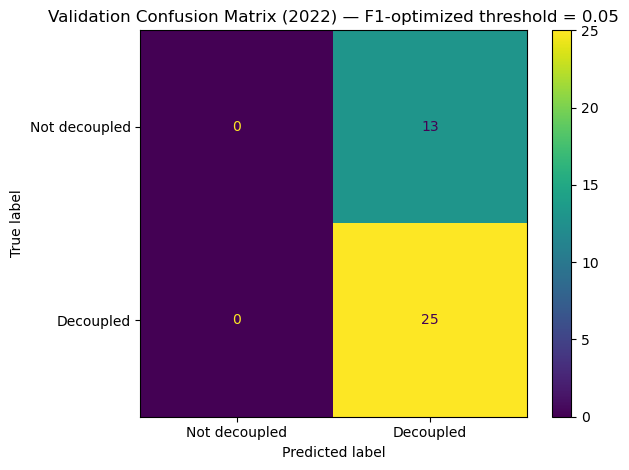

In [26]:
from src.data_loader import chronological_split
from src.models import make_logistic_model
from src.evaluation import find_best_threshold
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# split (same logic as main.py)
X_train, X_val, X_test, y_train, y_val, y_test, *_ = chronological_split(df)

# fit logistic model
model = make_logistic_model()
model.fit(X_train, y_train)

# predicted probabilities on validation set
p_val = model.predict_proba(X_val)[:, 1]

best_thresh, _ = find_best_threshold(y_val, p_val)

print("p_val shape:", p_val.shape)
print("best_thresh:", best_thresh)
print("type(best_thresh):", type(best_thresh))
print("shape(best_thresh):", getattr(best_thresh, "shape", None))

y_pred = (p_val >= best_thresh).astype(int)


# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=["Not decoupled", "Decoupled"]
)

plt.title(
    f"Validation Confusion Matrix (2022) — "
    f"F1-optimized threshold = {best_thresh:.2f}"
)
plt.tight_layout()
plt.savefig(FIG_PATH / "figure_A3_confusion_2022.png", dpi=300)
plt.show()
